In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange

Tesla V100-SXM2-32GB


In [2]:
import requests
requests.get("https://api.wandb.ai/status").status_code

import wandb
wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zhome/c9/0/203261/.netrc
wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 42):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.1.0+cu118
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 #| 960 | 1152
number_of_recycles = 2
padding_value = -5000

In [6]:
# ## Training variables
runID = uuid.uuid4()

## Output path
trained_model_dir = f"/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian/251116_{runID}"

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


### Loading PPint dataframe

In [7]:
path_to_mmseqs_clustering = "/work3/s232958/data/PPint_DB/3_å_dataset5_singlefasta/clusterRes40"
all_seqs, clust, clust_keys = pat_utils.mmseqs_parser(path_to_mmseqs_clustering)

path_to_interaction_df = "/work3/s232958/data/PPint_DB/disordered_interfaces_no_cutoff_filtered_nonredundant80_3å_5.csv.gz"
disordered_interfaces_df = pd.read_csv(path_to_interaction_df,index_col=0).reset_index(drop=True)
disordered_interfaces_df["PDB_chain_name"] = (disordered_interfaces_df["PDB"] + "_" + disordered_interfaces_df["chainname"]).tolist()
disordered_interfaces_df["index_num"] = np.arange(len(disordered_interfaces_df))
disordered_interfaces_df["chain_name_index"] = [row["PDB_chain_name"] + "_" + str(row["index_num"]) for index, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df = disordered_interfaces_df.set_index("PDB_interface_name")
disordered_interfaces_df["interface_residues"] = disordered_interfaces_df["interface_residues"].apply(lambda x: ast.literal_eval(x))
# disordered_interfaces_df["inter_chain_hamming"] = [1 - (Ldistance(seq.split("-")[0], seq.split("-")[1]))/np.max([len(seq.split("-")[0]), len(seq.split("-")[1])]) for seq in disordered_interfaces_df["protien_interface_sequences"]]
disordered_interfaces_df["dimer"] = disordered_interfaces_df["inter_chain_hamming"] > 0.60
disordered_interfaces_df["clust_keys"] = [clust_keys.get(row["chain_name_index"]) for index, row in disordered_interfaces_df.iterrows()] 

pdb_interface_and_clust_keys = {index:disordered_interfaces_df.loc[index,"clust_keys"].values.tolist() for index in tqdm(disordered_interfaces_df.index.drop_duplicates(), total=len(disordered_interfaces_df)/2)}
new_clusters, new_clusters_clustkeys = pat_utils.recluster_mmseqs_keys_to_non_overlapping_groups(pdb_interface_and_clust_keys)

### Creating train and test datasets based on train and test-idexes
train_indexes, test_indexes = pat_utils.run_train_test_partition(interaction_df=disordered_interfaces_df,
                                                    clustering=new_clusters, # Clusters from Bidentate-graphs
                                                    train_ratio=0.8, 
                                                    test_ratio=0.2, 
                                                    v=True, 
                                                    seed=0)

disordered_interfaces_df["ID"] = [row["PDB"]+"_"+str(row["interface_index"])+"_"+row["chainname"] for __, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df["PDB_interface_name"] = disordered_interfaces_df.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24725/24725.0 [00:38<00:00, 650.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 27834/27834 [00:00<00:00, 622334.00it/s]


0.8
0.2


In [8]:
print(f"Train indeces number: {len(train_indexes)}")
print(f"Test indeces number: {len(test_indexes)}")

Train indeces number: 19781
Test indeces number: 4944


In [9]:
# Creating new dataframe with pairs of proteins (PPints)
grouped = {}
for _, row in disordered_interfaces_df.iterrows():
    iface = row["PDB_interface_name"]
    seq = row["sequence"]
    rid = row["ID"]
    dimer = row["dimer"]
    
    if iface not in grouped:
        grouped[iface] = {
            "sequences": [],
            "IDs": [],
            "dimer": dimer,        # keep the dimer value for this interface
        }
    else:
        # Optional: sanity-check it's consistent per interface
        if grouped[iface]["dimer"] != dimer:
            print(f"Warning: multiple dimers for interface {iface}:",
                  grouped[iface]['dimer'], "vs", dimer)

    grouped[iface]["sequences"].append(seq)
    grouped[iface]["IDs"].append(rid)

records = []
for iface, vals in grouped.items():
    seqs = vals["sequences"]
    ids = vals["IDs"]
    if len(seqs) >= 2 and len(ids) >= 2:
        records.append({
            "interface_id": iface,
            "seq1": seqs[0],
            "seq2": seqs[1],
            "ID1": ids[0],
            "ID2": ids[1],
            "dimer": vals["dimer"],   # <- add dimer to final record
        })

PPint_interactions_NEW = pd.DataFrame(records)
PPint_interactions_NEW["seq_target_len"] = [len(row.seq1) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["seq_binder_len"] = [len(row.seq2) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["target_binder_id"] = PPint_interactions_NEW["ID1"] + "_" + PPint_interactions_NEW["ID2"]

PPint_interactions_NEW.head()

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
0,6NZA_0,MNTVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIH...,TVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIHAL...,6NZA_0_A,6NZA_0_B,True,461,459,6NZA_0_A_6NZA_0_B
1,9JKA_1,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,9JKA_1_B,9JKA_1_C,True,362,362,9JKA_1_B_9JKA_1_C
2,8DQ6_1,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,8DQ6_1_B,8DQ6_1_C,True,109,97,8DQ6_1_B_8DQ6_1_C
3,2YMZ_0,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,2YMZ_0_A,2YMZ_0_B,True,130,130,2YMZ_0_A_2YMZ_0_B
4,6IDB_0,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,6IDB_0_A,6IDB_0_B,False,317,172,6IDB_0_A_6IDB_0_B


In [11]:
# sample random 10%
train_indexes_sample = random.sample(train_indexes, int(len(train_indexes) * 0.1))
test_indexes_sample = random.sample(test_indexes, int(len(test_indexes) * 0.1))

In [25]:
Df_test = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(test_indexes_sample)]
Df_test

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
7,4POB_0,DHATVTVTDDSFQEDVVSSNKPVLVDFWATWCGPCKMVAPVLEEIA...,ATVTVTDDSFQEDVVSSNKPVLVDFWATWCGPCKMVAPVLEEIAKD...,4POB_0_A,4POB_0_B,True,107,105,4POB_0_A_4POB_0_B
12,7T6C_0,YYPFVRKALFQLDPERAHEFTFQQLRRITGTPFEALVRQKVPAKPV...,YYPFVRKALFQLDPERAHEFTFQQLRRITGTPFEALVRQKVPAKPV...,7T6C_0_A,7T6C_0_B,True,335,335,7T6C_0_A_7T6C_0_B
28,1EGP_0,LKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTL,YNRVRVFYNPGTNVVNHVPHVG,1EGP_0_A,1EGP_0_B,False,39,22,1EGP_0_A_1EGP_0_B
62,7YH3_0,KVENPLLISLYSHYVEQILSETNSIDDANQKLRDLGKELGQQIYLN...,KVENPLLISLYSHYVEQILSETNSIDDANQKLRDLGKELGQQIYLN...,7YH3_0_A,7YH3_0_C,True,150,155,7YH3_0_A_7YH3_0_C
70,4WMO_1,GYRSCNEIKSSDSRAPDGIYTLATEDGESYQTFCDTTNGGGWTLVA...,GYRSCNEIKSSDSRAPDGIYTLATEDGESYQTFCDTTNGGGWTLVA...,4WMO_1_D,4WMO_1_E,True,271,271,4WMO_1_D_4WMO_1_E
...,...,...,...,...,...,...,...,...,...
24455,2OYS_0,NKIFIYAGVRNHNSKTLEYTKRLSSIISSRNNVDISFRTPFNSELE...,NKIFIYAGVRNHNSKTLEYTKRLSSIISSRNNVDISFRTPFNSELE...,2OYS_0_A,2OYS_0_B,True,227,227,2OYS_0_A_2OYS_0_B
24491,6XRF_1,TLYRLHEADLEIPDAWQDQSINIFKLPASGPAREASFVISRDASQG...,MDAQAAARLGDEIAHGFGVAAMVAGAVAGALIGAAVVAAATGGLAA...,6XRF_1_B,6XRF_1_C,False,140,57,6XRF_1_B_6XRF_1_C
24507,5Z2L_0,GAFTGKTVLILGGSRGIGAAIVRRFVTDGANVRFTYAGSKDAAKRL...,GAFTGKTVLILGGSRGIGAAIVRRFVTDGANVRFTYAGSKDAAKRL...,5Z2L_0_A,5Z2L_0_B,True,239,243,5Z2L_0_A_5Z2L_0_B
24617,4LRS_0,APRVRITDSTLRDGSHAMAHQFTEEQVRATVHALDAAGVEVIEVSH...,GKAVAAIVGPGNIGTDLLIKLQRSEHIEVRYMVGVDPASEGLARAR...,4LRS_0_A,4LRS_0_B,False,337,294,4LRS_0_A_4LRS_0_B


In [20]:
# interaction_Dict = {}

# for _, row in Df_train.iterrows():
#     key_prot, seq_prot = row['ID1'], row['seq1']
#     key_pep, seq_pep = row['ID2'], row['seq2']
#     interaction_Dict[key_prot] = seq_prot
#     interaction_Dict[key_pep] = seq_pep

# for _, row in Df_test.iterrows():
#     key_prot, seq_prot = row['ID1'], row['seq1']
#     key_pep, seq_pep = row['ID2'], row['seq2']
#     interaction_Dict[key_prot] = seq_prot
#     interaction_Dict[key_pep] = seq_pep

# assert (len(list(interaction_Dict.items())) == (len(Df_test) + len(Df_train))*2)

In [34]:
# from pathlib import Path
# from esm.models.esmc import ESMC
# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig
# from esm.pretrained import get_esmc_model_tokenizers  

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# tokenizer = get_esmc_model_tokenizers()
# model = ESMC(
#     d_model=1152,
#     n_heads=18,
#     n_layers=36,
#     tokenizer=tokenizer,
# ).eval()

# weights_path = Path("/work3/s232958/models/esmc-600m-2024-12/data/weights/esmc_600m_2024_12_v0.pth")
# state_dict = torch.load(weights_path, map_location=device)

# model.load_state_dict(state_dict)
# client = model.to(device)  # or whatever variable you used
# client.eval()

# def calculate_ESM_pr_res_embeddings(sequence):
#     protein = ESMProtein(sequence=sequence)
#     protein_tensor = client.encode(protein)
#     logits_output = client.logits(
#     protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
#     )
#     return logits_output.embeddings.detach().cpu().numpy()

# def to_numpy(x):
#     try:
#         return x.detach().cpu().numpy()
#     except AttributeError:
#         return np.asarray(x)

/work3/s232958/tmp/ipykernel_2521746/783615165.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


In [38]:
# path_to_output_embeddings = "/work3/s232958/data/PPint_DB/embeddings_esmC"

# for name, seq in tqdm(interaction_Dict.items(), total=len(interaction_Dict.items()), desc="Embedding PPint"):
#     emb = calculate_ESM_pr_res_embeddings(seq)
#     emb_np = to_numpy(emb)
#     out_path = os.path.join(path_to_output_embeddings, f"{name}.npy")
#     np.save(out_path, emb_np)
#     # print(f"Protein {name} embedded and saved to {out_path}")

Embedding PPint: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 4944/4944 [04:17<00:00, 19.20it/s]


#### CLIP_PPint_analysis_dataset

In [26]:
class CLIP_PPint_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1152,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESMC embeddings"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:3])
            bnd_id = "_".join(parts[3:])

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/PPint_DB/embeddings_esmC"
temb_path = "/work3/s232958/data/PPint_DB/embeddings_esmC"

testing_Dataset = CLIP_PPint_analysis_dataset(
    Df_test,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

#Loading ESMC embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████| 494/494 [00:10<00:00, 48.24it/s]


#### ESMC embedding meta-analysis dataset

In [49]:
# meta_targets, meta_binders = {}, {}

# for _, row in interaction_df_shuffled.iterrows():
#     key_prot, seq_prot = row['target_id'], row['seq_target']
#     key_pep, seq_pep = row['binder_id'], row['seq_binder']
#     if key_prot not in meta_targets.keys():
#         meta_targets[key_prot] = seq_prot
#     else:
#         pass
#     meta_binders[key_pep] = seq_pep

# from pathlib import Path
# from esm.models.esmc import ESMC
# from esm.pretrained import get_esmc_model_tokenizers  

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# tokenizer = get_esmc_model_tokenizers()
# model = ESMC(
#     d_model=1152,
#     n_heads=18,
#     n_layers=36,
#     tokenizer=tokenizer,
# ).eval()

# weights_path = Path("/work3/s232958/models/esmc-600m-2024-12/data/weights/esmc_600m_2024_12_v0.pth")
# state_dict = torch.load(weights_path, map_location=device)

# model.load_state_dict(state_dict)
# client = model.to(device)  # or whatever variable you used
# client.eval()

# def calculate_ESM_pr_res_embeddings(sequence):
#     protein = ESMProtein(sequence=sequence)
#     protein_tensor = client.encode(protein)
#     logits_output = client.logits(
#     protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
#     )
#     return logits_output.embeddings.detach().cpu().numpy()

# def to_numpy(x):
#     try:
#         return x.detach().cpu().numpy()
#     except AttributeError:
#         return np.asarray(x)

# for name, seq in tqdm(meta_targets.items(), total=len(meta_targets.items()), desc="Embedding Meta targets"):
#     emb = calculate_ESM_pr_res_embeddings(seq)
#     emb_np = to_numpy(emb)
#     out_path = os.path.join("/work3/s232958/data/meta_analysis/targets_embeddings_esmC", f"{name}.npy")
#     np.save(out_path, emb_np)
#     # print(f"Protein {name} embedded and saved to {out_path}")

# for name, seq in tqdm(meta_binders.items(), total=len(meta_binders.items()), desc="Embedding Meta binders"):
#     emb = calculate_ESM_pr_res_embeddings(seq)
#     emb_np = to_numpy(emb)
#     out_path = os.path.join("/work3/s232958/data/meta_analysis/binders_embeddings_esmC", f"{name}.npy")
#     np.save(out_path, emb_np)
#     # print(f"Protein {name} embedded and saved to {out_path}")

/work3/s232958/tmp/ipykernel_2521746/3709663317.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)
Embedding Met

#### Loading MetaData

In [51]:
class CLIP_PPint_MetaData(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1152,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        return binder_emb, target_emb, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/meta_analysis/binders_embeddings_esmC"
temb_path = "/work3/s232958/data/meta_analysis/targets_embeddings_esmC"

validation_Dataset = CLIP_PPint_MetaData(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

#Loading ESM2 embeddings: 100%|████████████████████████████████████████████████████████████████████████████████| 3532/3532 [00:17<00:00, 197.37it/s]


In [52]:
accessions_Meta = list(interaction_df_shuffled.binder_id)
emb_b, emb_t, labels = validation_Dataset._get_by_name(accessions_Meta[:5])
labels

tensor([1, 0, 0, 0, 0])

### Train model from scratch with 10% of PPint dataset using old architecture (encodings only)

In [27]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=embedding_dimension, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_trans  
            prot_emb = prot_emb + prot_trans

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding), dim=-1)
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding), dim=-1)
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        positive_logits = self.forward(embedding_pep, embedding_prot)
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], 
                          embedding_prot[cols,:,:], 
                          int_prob=0.0)

        # loss of predicting partner using peptide
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self(embedding_pep, embedding_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
    
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_binder, embedding_target, labels = batch
        embedding_binder = embedding_binder.to(device)
        embedding_target = embedding_target.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_binder, embedding_target)
            logits = logits.float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = self(embedding_pep, embedding_prot)
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

### Loading pre-trained model

### ESM-C

In [30]:
model = MiniCLIP_w_transformer_crossattn(embed_dimension=embedding_dimension, num_recycles=number_of_recycles).to("cuda")
path = "/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian/251116_0e035ba9-3cbd-4aab-be0b-cc2e37723b27/0e035ba9-3cbd-4aab-be0b-cc2e37723b27_checkpoint_8/0e035ba9-3cbd-4aab-be0b-cc2e37723b27_checkpoint_epoch_8.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [33]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    lbls = torch.tensor([x[2].float() for x in batch])
    return b_emb, t_emb, lbls

test_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)

In [46]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        positive_logits = model(embedding_pep, embedding_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device="cuda")
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device="cuda")
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:18,  2.77it/s]                                                                                            

Positives: (494,)
Negatives: (2211,)


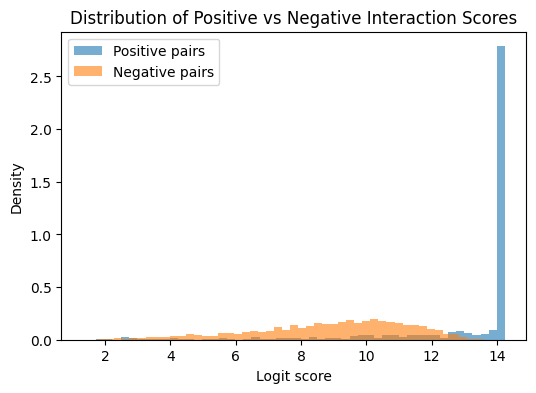

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [53]:
Df_test_non_dimer = Df_test[Df_test.dimer == False]

non_dimers_Dataset = CLIP_PPint_analysis_dataset(
    Df_test_non_dimer,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

non_dimers_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)

#Loading ESMC embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [00:01<00:00, 118.92it/s]


In [55]:
interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(Df_test_non_dimer)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(logits.unsqueeze(0))

# Convert list of tensors to single 1D tensors
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
# interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

predicted_interaction_scores

#Iterating through batched data: 50it [00:04, 10.22it/s]                                                                                            


array([14.19217 , 14.252893,  8.744677, 14.229164, 14.252892, 14.241057,
       10.360923, 14.211796, 14.252892, 11.652437, 14.19217 , 14.252893,
        8.744677, 14.229164, 14.252892, 14.241057, 10.360923, 14.211796,
       14.252892, 11.652437, 14.19217 , 14.252893,  8.744677, 14.229164,
       14.252892, 14.241057, 10.360923, 14.211796, 14.252892, 11.652437,
       14.19217 , 14.252893,  8.744677, 14.229164, 14.252892, 14.241057,
       10.360923, 14.211796, 14.252892, 11.652437, 14.19217 , 14.252893,
        8.744677, 14.229164, 14.252892, 14.241057, 10.360923, 14.211796,
       14.252892, 11.652437, 14.19217 , 14.252893,  8.744677, 14.229164,
       14.252892, 14.241057, 10.360923, 14.211796, 14.252892, 11.652437,
       14.19217 , 14.252893,  8.744677, 14.229164, 14.252892, 14.241057,
       10.360923, 14.211796, 14.252892, 11.652437, 14.19217 , 14.252893,
        8.744677, 14.229164, 14.252892, 14.241057, 10.360923, 14.211796,
       14.252892, 11.652437, 14.19217 , 14.252893, 